## Imports

In [1]:
# !pip install -U regdata

In [2]:
import regdata as rd
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import wbml.out as out
from wbml.plot import tweak

from stheno import B, GP, EQ, PseudoObsVFE, PseudoObsFITC
from varz.torch import Vars, minimise_l_bfgs_b, parametrised, Positive
import lab.torch

## Data preperation

In [3]:
# Define points to predict at.
x = B.linspace(0, 10, 100)
x_obs = B.linspace(0, 7, 50_000)
x_ind = B.linspace(0, 10, 20)

# Construct a prior.
f = GP(EQ().periodic(2 * B.pi))

# Sample a true, underlying function and observations.
f_true = B.sin(x)
y_obs = B.sin(x_obs) + B.sqrt(0.5) * B.randn(*x_obs.shape)

## Plotting function

In [4]:
def plot(method):
    if method == 'VFE':
        # Plot result.
        plt.plot(x, f_true, label="True", style="test")
        plt.scatter(
            x_obs,
            y_obs,
            label="Observations",
            style="train",
            c="tab:green",
            alpha=0.35,
        )
        plt.scatter(
            x_ind,
            obs.mu(f.measure)[:, 0],
            label="Inducing Points",
            style="train",
            s=20,
        )
        plt.plot(x, mean, label="Prediction", style="pred")
        plt.fill_between(x, lower, upper, style="pred")
        tweak()

        plt.show()
    else:
        # Plot result.
        plt.plot(x, f_true, label="True", style="test")
        plt.scatter(
            x_obs,
            y_obs,
            label="Observations",
            style="train",
            c="tab:green",
            alpha=0.35,
        )
        plt.scatter(
            x_ind,
            B.dense(f_post(x_ind).mean),
            label="Inducing Points",
            style="train",
            s=20,
        )
        plt.plot(x, mean, label="Prediction", style="pred")
        plt.fill_between(x, lower, upper, style="pred")
        tweak()

        plt.show()

## Sparse regression with Variational Free Energy (VFE) method

ELBO:       -5.345e+04


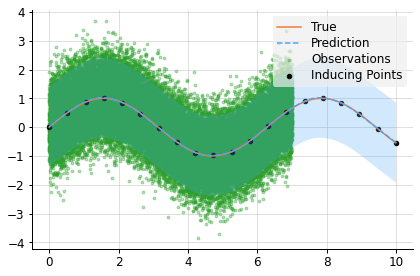

In [5]:
# Compute a pseudo-point approximation of the posterior.
obs = PseudoObsVFE(f(x_ind), (f(x_obs, 0.5), y_obs))

# Compute the ELBO.
out.kv("ELBO", obs.elbo(f.measure))

# Compute the approximate posterior.
f_post = f | obs

# Make predictions with the approximate posterior.
mean, lower, upper = f_post(x, 0.5).marginal_credible_bounds()
plot('VFE')

## Sparse Regression with Fully Independent Training Conditional (FITC) mehod

ELBO:       -5.345e+04


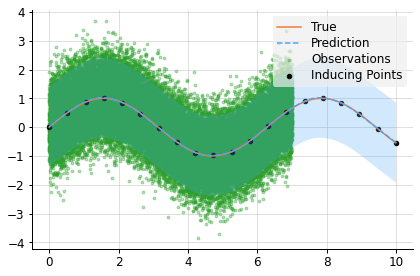

In [6]:
# Compute a pseudo-point approximation of the posterior.
obs = PseudoObsFITC(f(x_ind), (f(x_obs, 0.5), y_obs))

# Compute the ELBO.
out.kv("ELBO", obs.elbo(f.measure))

# Compute the approximate posterior.
f_post = f | obs

# Make predictions with the approximate posterior.
mean, lower, upper = f_post(x, 0.5).marginal_credible_bounds()
plot('FITC')

## Hyperparameter tuning (Noisy Sine data)

In [7]:
def model(vs):
    """Constuct a model with learnable parameters."""
    return vs['variance']*GP(EQ().stretch(vs['length_scale']))

In [8]:
torch.manual_seed(123)

dataObj = rd.SineNoisy(scale_X=False, scale_y=False, return_test=True, backend='torch')
x_obs, y_obs, x = dataObj.get_data()

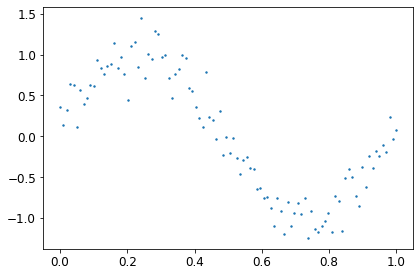

In [9]:
plt.scatter(x_obs, y_obs, s=2);

### VFE

In [17]:
vs = Vars(torch.float64)
vs.positive(name="noise")
vs.positive(name="length_scale");
vs.positive(name="variance");
vs.positive(init=torch.linspace(0.4,0.6,10), shape=(10,), name='x_ind')
vs.requires_grad(True)

optimizer = torch.optim.Adam(vs.get_latent_vars(), lr=0.1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
losses = []

def update(i):
    optimizer.zero_grad()
    gp = model(vs)
    obs = PseudoObsVFE(gp(vs['x_ind']), (gp(x_obs, vs['noise']), y_obs))
    loss = -obs.elbo(gp.measure)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    gp_post = gp | obs
    mean, lower, upper = gp_post(x, vs['noise']).marginal_credible_bounds()
    ind_mean = B.dense(gp_post(vs['x_ind']).mean)
    
    ax[0].cla();ax[1].cla();
    ax[0].scatter(x_obs, y_obs, s=2)
    with torch.no_grad():
        ax[0].plot()
        ax[0].plot(x, B.dense(mean), label='Prediction')
        ax[0].fill_between(x.ravel(), lower, upper, alpha=0.2, label='Uncertainty')
        ax[0].plot(x, dataObj.f(x), label='True')
        ax[0].scatter(vs['x_ind'], ind_mean, label='Inducing points')
    ax[0].set_xlabel('X')
    ax[0].legend()
    
    ax[1].plot(losses, label='loss')
    ax[1].set_xlabel('Iterations')
    ax[1].legend()
    
anim = FuncAnimation(fig, update, range(50))
rc('animation', html='jshtml')
plt.close()
anim

### FITC

In [18]:
vs = Vars(torch.float64)
vs.positive(name="noise")
vs.positive(name="length_scale");
vs.positive(name="variance");
vs.positive(init=torch.linspace(0.4,0.6,10), shape=(10,), name='x_ind')
vs.requires_grad(True)

optimizer = torch.optim.Adam(vs.get_latent_vars(), lr=0.1)
fig, ax = plt.subplots(1,2,figsize=(15,5))
losses = []

def update(i):
    optimizer.zero_grad()
    gp = model(vs)
    obs = PseudoObsFITC(gp(vs['x_ind']), (gp(x_obs, vs['noise']), y_obs))
    loss = -obs.elbo(gp.measure)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    
    gp_post = gp | obs
    mean, lower, upper = gp_post(x, vs['noise']).marginal_credible_bounds()
    ind_mean = B.dense(gp_post(vs['x_ind']).mean)
    
    ax[0].cla();ax[1].cla();
    ax[0].scatter(x_obs, y_obs, s=2)
    with torch.no_grad():
        ax[0].plot()
        ax[0].plot(x, B.dense(mean), label='Prediction')
        ax[0].fill_between(x.ravel(), lower, upper, alpha=0.2, label='Uncertainty')
        ax[0].plot(x, dataObj.f(x), label='True')
        ax[0].scatter(vs['x_ind'], ind_mean, label='Inducing points')
    ax[0].set_xlabel('X')
    ax[0].legend()
    
    ax[1].plot(losses, label='loss')
    ax[1].set_xlabel('Iterations')
    ax[1].legend()
    
anim = FuncAnimation(fig, update, range(50))
rc('animation', html='jshtml')
plt.close()
anim